<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This tutorial by Xiaozhou Li is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

# Finite Difference Methods - 2D Elliptic Problem 

## Laplace's equation
Consider the Laplace's equation given as 
$$
    \nabla^2 u = 0,\quad\quad (x,y) \in D,
$$
where $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$, and the boundary conditions are given as
![Boundary Conditions](img/BCs.png)

## Finite Difference Approximation
Here, we use a rectangular grid $(x_i,y_j)$, where
$$
    x_i = i\Delta x, \,\,\text{for }\, i = 0,1,\ldots,N+1;\quad y_j = j\Delta y,\,\,\text{for }\, j = 0,1,\ldots,M+1.
$$
Five-points scheme:
$$
    -\lambda^2 u_{i+1,j} + 2(1+\lambda^2)u_{i,j} - \lambda^2u_{i-1,j} - u_{i,j+1} - u_{i,j-1} = 0,\quad\text{for}\,\, i = 1,\ldots,N,\,\, j = 1,\ldots,M，
$$
where $\lambda = \frac{\Delta y}{\Delta x}$. The boundary conditions are 
- $x = 0: u_{0,j} = g_L(y_j), \quad\text{for }\, j = 1,\ldots,M$,
- $x = a: u_{N+1,j} = g_R(y_j), \quad\text{for }\, j = 1,\ldots,M$,
- $y = 0: u_{i,0} = g_B(x_i), \quad\text{for }\, i = 1,\ldots,N$,
- $y = b: u_{i,M+1} = g_T(x_i), \quad\text{for }\, i = 1,\ldots,N$.

### Building the matrix 
Now, we assemble all $N\times M$ equations into a matrix equation $A v = b$, where $A$ is a $(N\times M)\times(N\times M)$ matrix and the vector $v$ contains the unknowns.  Before assembling the matrix $A$, we first need to linearly order the $u_{i,j}$ to construct this vector.  Here, we will use the common row-major ordering, which yields
$$
    v = \left[u_{1,1},\ldots,u_{N,1},u_{1,2},\ldots,u_{N,2},\ldots,u_{1,M},\ldots,u_{N,M}\right]^T.
$$
In general, the formula connecting $v_\ell$ with $u_{i,j}$ is 
$$
    v_\ell = u_{i,j},\quad\text{for}\,\,\ell = (j-1)N + i.
$$
Then the five-points scheme becomes
$$
    -\lambda^2 v_{\ell+1} + 2(1+\lambda^2)v_{\ell} - \lambda^2v_{\ell-1} - v_{\ell+N} - v_{\ell-N} = 0,\quad\text{for}\,\, \ell = 1,\ldots,N\times M,
$$
which can be written in matrix form as 
$$
    A v = b.
$$
However, at points next to a boundary one or more of the term $v_{\ell\pm1}$ and $v_{\ell\pm N}$ must be modified to account for the boundary conditions. 

#### Assemble Matrix $A$
For general case the matrix $A$ (size $(N\times M)\times(N\times M)$) has the structure shown as follows:
\begin{equation*}
    A = \left(\begin{array}{ccccccc}T & D & & & & \\ D & T & D & & 0 & \\ & D & T & D & & \\
                                    & & \ddots & \ddots & \ddots & \\ & 0 & & D & T & D \\ 
                                    & & & & D & T\end{array}\right).
\end{equation*}
Here, the tridiagonal matrix $T$ (size $N \times N$)
\begin{equation*}
    T = \left(\begin{array}{ccccccc}\beta & -\lambda^2 & & & & \\ -\lambda^2 & \beta & -\lambda^2 & & 0 & \\ 
                                    & -\lambda^2 & \beta & -\lambda^2 & & \\
                                    & & \ddots & \ddots & \ddots & \\ & 0 & & -\lambda^2 & \beta & -\lambda^2 \\ 
                                    & & & & -\lambda^2 & \beta\end{array}\right),
\end{equation*}
and the diagonal matrix $D$ (size $N \times N$)
\begin{equation*}
    D = -I.
\end{equation*}

In [13]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

In [14]:
# environment setting, before any codes
import numpy as np
import numpy.polynomial.legendre as npleg

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

In [15]:
def generate_TD(N, dx, dy):
    T = np.zeros([N,N])
    a = - (dy/dx)**2
    b = 2*(1 - a)
    for i in range(N):
        T[i,i] += b
        if (i < N-1):
            T[i,i+1] += a
        if (i > 0):
            T[i,i-1] += a
    D = -np.identity(N)
    return T, D

<IPython.core.display.Javascript object>


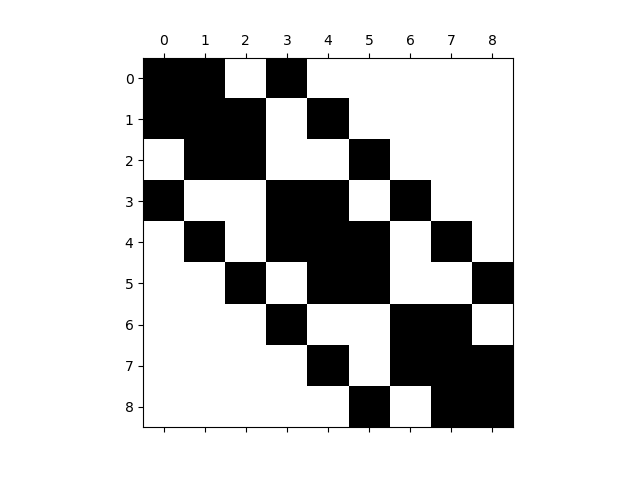

In [16]:
def assemble_matrix_A(dx, dy, N, M):
    T, D = generate_TD(N, dx, dy)
    A = np.zeros([N*M, N*M])
    for j in range(M):
        A[j*N:(j+1)*N,j*N:(j+1)*N] += T
        if (j < M-1):
            A[j*N:(j+1)*N,(j+1)*N:(j+2)*N] += D
        if (j > 0):
            A[j*N:(j+1)*N,(j-1)*N:j*N] += D
    return A

N = 3
M = 3
dx = 1./(N+1)
dy = 1./(M+1)
T, D = generate_TD(N, dx, dy)
#print (T)
A = assemble_matrix_A(dx, dy, N, M)
#print (A)
plt.spy(A)
plt.show()

#### Assemble Vector $b$
- Most components of $b$ are zeros,
- If $v_\ell$ is next to a boundary or more, then $b_\ell$ must be modified to account for the boundary condition,
- In two dimension, only $2 N\times M - 2$ components of $b$ is affected by the boundary conditions.
- Left boundary $g_L$: $b_{j N} += \lambda^2 g_L(y_{j+1})$ for $j = 0,\ldots,M-1$,
- Right boundary $g_R$: $b_{j N + N-1} += \lambda^2 g_R(y_{j+1})$ for $j = 0,\ldots,M-1$,
- Bottom boundary $g_B$: $b_{i} += g_B(x_{i+1})$ for $i = 0, \ldots,N-1$,
- Top boundary $g_T$: $b_{(M-1)*N + i} += g_T(x_{i+1})$ for $i = 0, \ldots,N-1$. 

In [17]:
# Set boundary conditions
def gL(y):
    return 0.

def gR(y):
    return 0.

def gB(x):
    return 0.

def gT(x):
    return 1.
    #return x*(1-x)*(4./5-x)*np.exp(6*x)

In [18]:
def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT):
    b = np.zeros(N*M)
    # Left BCs
    for j in range(M):
        b[j*N] += (dy/dx)**2*gL(y[j+1]) 
    
    # Right BCs
    for j in range(M):
        b[j*N] += (dy/dx)**2*gR(y[j+1])
    
    # Bottom BCs
    for i in range(N):
        b[i] += gB(x[i+1])
        
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += gT(x[i+1])
    return b

<IPython.core.display.Javascript object>


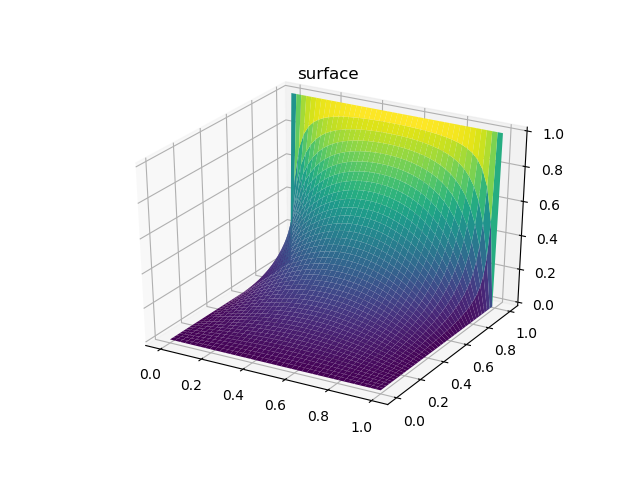

In [19]:
def Laplace_solver(a, b, N, M, gL, gR, gB, gT):
    dx = b/(M+1)
    dy = a/(N+1)
    x = np.linspace(0, a, N+2)
    y = np.linspace(0, b, M+2)
    
    A = assemble_matrix_A(dx, dy, N, M)
    b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT)
    
    v = np.linalg.solve(A,b)
    
    # add boundary points + plotting
    u = np.zeros([(N+2),(M+2)])
    #u[1:(N+1),1:(M+1)] = np.reshape(v, (N, M))
    # Top BCs
    for i in range(N+2):
        u[i,M+1] = gT(x[i])
    u = np.transpose(u)
    u[1:(M+1),1:(N+1)] = np.reshape(v, (M, N))

    
    X, Y = np.meshgrid(x, y)
    #Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)

    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.plot_surface(X, Y, u, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('surface')
    plt.show()
    
Laplace_solver(1, 1, 40, 40, gL, gR, gB, gT)

### Examples 

#### Examples 1
$$ 
    g_T(x) = \sin(\lambda_5 x),
$$
where $\lambda_n = \frac{n\pi}{a}$.  The exaction solution is 
$$
    u(x,y) = \frac{\sinh(\lambda_5 y)}{\sinh(\lambda_5 b)}\sin(\lambda_5 x).
$$
Here, we simply assume $a = b = 1$

<IPython.core.display.Javascript object>


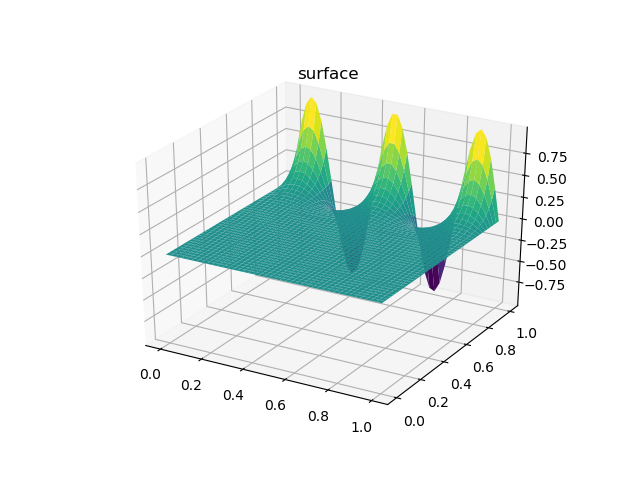

In [20]:
def gT_ex1(x):
    return np.sin(5*np.pi*x)

def u_ex1(x, y):
    return np.sinh(5*np.pi*y)/np.sinh(5*np.pi)*np.sin(5*np.pi*x)

Laplace_solver(1, 1, 40, 40, gL, gR, gB, gT_ex1)

#### Examples 2
$$ 
    g_T(x) = x(1-x)(\frac{4}{5}-x)e^{6x}.
$$
The fourier coefficient of exaction solution is 
$$
    a_n = \frac{12\lambda_n(4\gamma_n(\lambda_n^2 - 36)(\lambda_n^2+6) - 672\lambda_n^2 - 5\lambda_n^4 - 26352)}{5\sinh(\lambda_n)(\lambda_n^2 + 36)^4}
$$
where $\gamma_n = (-1)^n e^6$.  Here, we simply assume $a = b = 1$

<IPython.core.display.Javascript object>


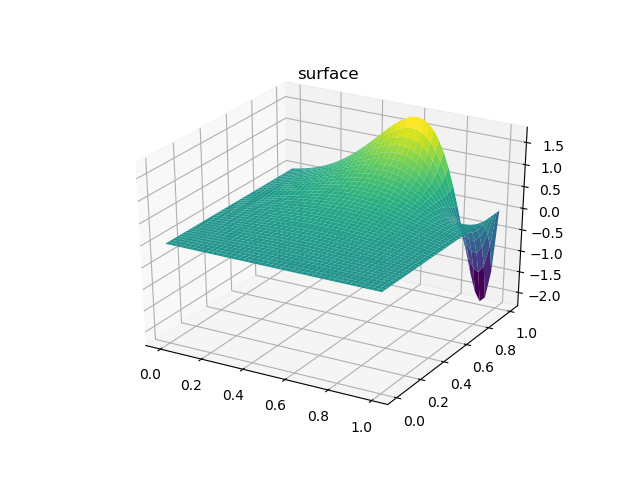

In [21]:
def gT_ex2(x):
    return x*(1-x)*(4./5-x)*np.exp(6*x)

#def u_ex2(x, y):
#    return np.sinh(5*np.pi*y)/np.sinh(5*np.pi)*np.sin(5*np.pi*x)

Laplace_solver(1, 1, 40, 40, gL, gR, gB, gT_ex2)

#### Examples 3
$$ 
    g_T(x) = \left\{\begin{array}{cl} 1 & \text{if } \frac{1}{4} \leq x \leq \frac{3}{4}, \\
                                      0 & \text{otherwise}\end{array}\right..
$$
Assuming $\frac{3}{4} < a$, the fourier coefficient of exaction solution is given as 
$$
    a_n = \frac{2}{a\lambda_n\sinh(\lambda_n b)}(\cos(\lambda_n/4) - \cos(3\lambda_n/4)),
$$
where $\lambda_n = \frac{n\pi}{a}$.  Here, we simply assume $a = b = 1$

<IPython.core.display.Javascript object>


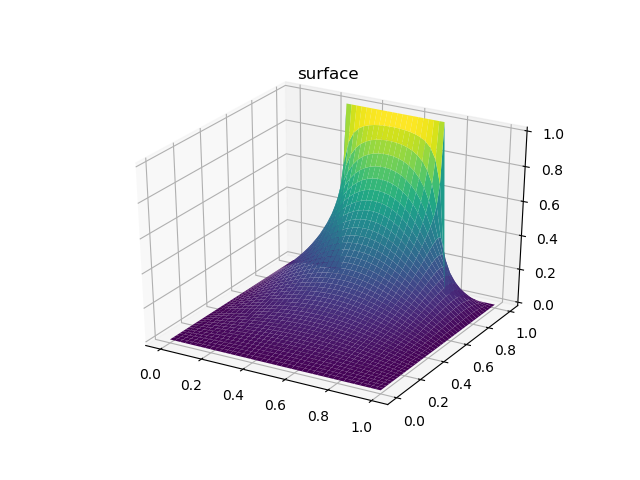

In [22]:
def gT_ex3(x):
    if (x >= 0.25 and x <= 0.75):
        return 1.
    else:
        return 0.

Laplace_solver(1, 1,40, 40, gL, gR, gB, gT_ex3)

### How to Exam the Errors?

In [23]:
def gT_ex4(x):
    return np.sin(5*np.pi*x)

def u_ex4(x, y):
    return np.sinh(5*np.pi*y)/np.sinh(5*np.pi)*np.sin(5*np.pi*x)

def Laplace_error(a, b, N, M, gL, gR, gB, gT, u_exact):
    dx = b/(M+1)
    dy = a/(N+1)
    x = np.linspace(0, a, N+2)
    y = np.linspace(0, b, M+2)
    
    A = assemble_matrix_A(dx, dy, N, M)
    b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT)
    
    v = np.linalg.solve(A,b)
    
    erri = 0.
    err = np.zeros([N,M])
    for i in range(N):
        for j in range(M):
            err[i,j] = np.abs(u_exact(x[i+1],y[j+1]) - v[j*N+i])
            erri = max(err[i,j], erri)    
    return erri
    
def Order_Verify(num, a, b, N0, M0, gL, gR, gB, gT, u_exact):
    erri = np.zeros(num)
    
    for i in range(num):
        erri[i] = Laplace_error(a, b, N0*2**i, M0*2**i, gL, gR, gB, gT, u_exact)
    
    print (" N    M  maximum error    order")
    for i in range(np.size(erri)):
        if (i == 0):
            print ("%-3d  %-3d  %9.2e        --" % (N0, M0, erri[i]))
        else:
            print ("%-3d  %-3d  %9.2e       %4.2f" % (N0*2**i, M0*2**i, erri[i], np.log(erri[i-1]/erri[i])/np.log(2)))
    
    
Order_Verify(4, 1, 1, 10, 10, gL, gR, gB, gT_ex4, u_ex4)

 N    M  maximum error    order
10   10    5.18e-02        --
20   20    1.57e-02       1.72
40   40    4.40e-03       1.83
80   80    1.15e-03       1.94


## The Conjugate Gradient Method

In [24]:
def CG(A, b, x0, n):
    r_new = b - np.dot(A, x0) 
    r_old = np.copy(np.size(x0))
    d_old = np.zeros(np.size(x0))
    x = np.copy(x0)
    for k in range(n):
        if (k == 0):
            d_new = np.copy(r_new)
        else:
            beta = np.dot(r_new,r_new)/np.dot(r_old,r_old)
            d_new = r_new + beta*d_old
        Ad = np.dot(A, d_new)
        alpha = np.dot(r_new,r_new)/np.dot(d_new,Ad)
        x += alpha*d_new
        d_old = d_new
        r_old = r_new
        r_new = r_old - alpha*Ad
    return x

def CG_Test(A, b, x0, x_exact, n):
    r_new = b - np.dot(A, x0) 
    r_old = np.copy(np.size(x0))
    d_old = np.zeros(np.size(x0))
    x = np.copy(x0)
    err_A = np.zeros(n)
    err2 = np.zeros(n)
    print ("iteration number   A-norm     2-norm")
    for k in range(n):
        if (k == 0):
            d_new = np.copy(r_new)
        else:
            beta = np.dot(r_new,r_new)/np.dot(r_old,r_old)
            d_new = r_new + beta*d_old
        Ad = np.dot(A, d_new)
        alpha = np.dot(r_new,r_new)/np.dot(d_new,Ad)
        x += alpha*d_new
        d_old = d_new
        r_old = r_new
        r_new = r_old - alpha*Ad
        err = x - x_exact
        err_A[k] = np.sqrt(np.dot(np.dot(err, A),err))
        err2[k] = np.sqrt(np.dot(err,err))
        print ("%3dth iteration  %9.2e  %9.2e" % (k, err_A[k], err2[k]))
    return x, err_A
        
def Laplace_CG(a, b, N, M, gL, gR, gB, gT, u_exact):
    dx = b/(M+1)
    dy = a/(N+1)
    x = np.linspace(0, a, N+2)
    y = np.linspace(0, b, M+2)
    
    A = assemble_matrix_A(dx, dy, N, M)
    b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT)
    
    # direct method
    v = np.linalg.solve(A,b)
    
    # CG
    v0 = np.zeros(np.size(v))
    #for i in range(10):
    #    print (i, np.linalg.norm(v - CG(A, b, v0, i)))
    v_CG, err_A = CG_Test(A, b, v0, v, 40)
    #plt.plot(range(20), err_A)
    #plt.show()
        
Laplace_CG(1, 1, 40, 40, gL, gR, gB, gT_ex4, u_ex4)

iteration number   A-norm     2-norm
  0th iteration   2.12e+00   3.08e+00
  1th iteration   1.35e+00   2.21e+00
  2th iteration   8.99e-01   1.57e+00
  3th iteration   6.08e-01   1.10e+00
  4th iteration   4.14e-01   7.63e-01
  5th iteration   2.82e-01   5.27e-01
  6th iteration   1.93e-01   3.62e-01
  7th iteration   1.32e-01   2.49e-01
  8th iteration   9.05e-02   1.71e-01
  9th iteration   6.20e-02   1.17e-01
 10th iteration   4.25e-02   8.02e-02
 11th iteration   2.91e-02   5.49e-02
 12th iteration   1.99e-02   3.76e-02
 13th iteration   1.36e-02   2.58e-02
 14th iteration   9.34e-03   1.76e-02
 15th iteration   6.40e-03   1.21e-02
 16th iteration   4.38e-03   8.28e-03
 17th iteration   3.00e-03   5.67e-03
 18th iteration   2.06e-03   3.88e-03
 19th iteration   1.41e-03   2.66e-03
 20th iteration   9.65e-04   1.82e-03
 21th iteration   6.74e-04   1.27e-03
 22th iteration   5.43e-04   1.01e-03
 23th iteration   4.00e-04   7.55e-04
 24th iteration   2.79e-04   5.25e-04
 25th iterati

## Possion Problem
Consider the Possion problem given as 
$$
    \nabla^2 u = f(x,y),\quad\quad (x,y) \in D,
$$
where $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$, and the boundary conditions are given as
![Boundary Conditions](img/BCs.png)

__Exercise__ The exact solution is $u(x,y) = e^{x + \frac{y}{2}}$, using Dirichlet boundary conditions and the right hand side $f(x,y) = \frac{5}{4}e^{x+ \frac{y}{2}}$.

In [88]:
# Set source term
def fun(x,y):
    return 1.25*np.exp(x + 0.5*y)

def exact_u(x,y):
    return np.exp(x + 0.5*y)

# Set boundary conditions
def gL(y):
    return np.exp(0.5*y)

def gR(y):
    return np.exp(1 + 0.5*y)

def gB(x):
    return np.exp(x)

def gT(x):
    return np.exp(x + 0.5)

In [89]:
def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT, fun):
    b = np.zeros(N*M)
    # Source term
    for i in range(N):
        for j in range(M):
            b[j*N + i] = fun(x[i+1], y[j+1])
    b = -b*dy**2
            
    # Left BCs
    for j in range(M):
        b[j*N] += (dy/dx)**2*gL(y[j+1]) 
    
    # Right BCs
    for j in range(M):
        b[j*N+N-1] += (dy/dx)**2*gR(y[j+1])
    
    # Bottom BCs
    for i in range(N):
        b[i] += gB(x[i+1])
        
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += gT(x[i+1])
    return b


<IPython.core.display.Javascript object>


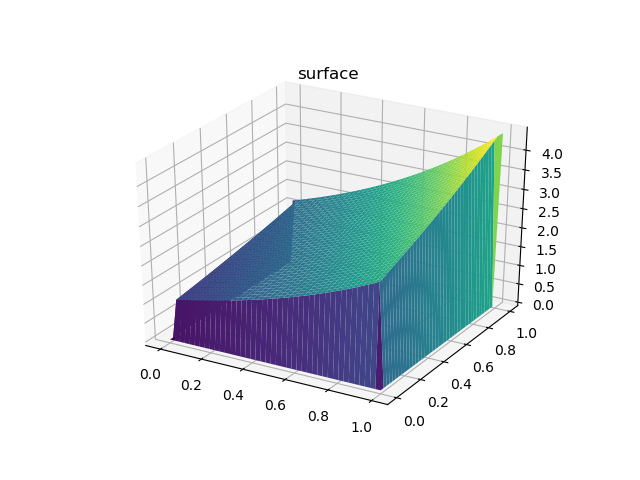

In [90]:
def Possion_solver(a, b, N, M, gL, gR, gB, gT, fun):
    dx = b/(M+1)
    dy = a/(N+1)
    x = np.linspace(0, a, N+2)
    y = np.linspace(0, b, M+2)
    
    A = assemble_matrix_A(dx, dy, N, M)
    b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT, fun)
    
    v = np.linalg.solve(A,b)
    
    # add boundary points + plotting
    u = np.zeros([(N+2),(M+2)])
    #u[1:(N+1),1:(M+1)] = np.reshape(v, (N, M))
    # Top BCs
    for i in range(N+2):
        u[i,M+1] = gT(x[i])
    u = np.transpose(u)
    u[1:(M+1),1:(N+1)] = np.reshape(v, (M, N))

    
    X, Y = np.meshgrid(x, y)
    #Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)

    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.plot_surface(X, Y, u, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('surface')
    plt.show()
    
Possion_solver(1, 1, 40, 40, gL, gR, gB, gT, fun)

In [91]:
def Possion_error(a, b, N, M, gL, gR, gB, gT, fun, u_exact):
    dx = b/(M+1)
    dy = a/(N+1)
    x = np.linspace(0, a, N+2)
    y = np.linspace(0, b, M+2)
    
    A = assemble_matrix_A(dx, dy, N, M)
    b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT, fun)
    
    v = np.linalg.solve(A,b)
    
    erri = 0.
    err = np.zeros([N,M])
    for i in range(N):
        for j in range(M):
            err[i,j] = np.abs(u_exact(x[i+1],y[j+1]) - v[j*N+i])
            erri = max(err[i,j], erri)    
            
    #X, Y = np.meshgrid(x[1:N+1], y[1:M+1])
    #Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)

    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #ax = fig.add_subplot(1, 1, 1, projection='3d')

    #ax.plot_surface(X, Y, err, rstride=1, cstride=1,
    #               cmap='viridis', edgecolor='none')
    #ax.set_title('error')
    #plt.show()
    return erri

Possion_error(1, 1, 40, 40, gL, gR, gB, gT, fun, exact_u)

8.601385716122678e-06

In [92]:
def Order_Verify(num, a, b, N0, M0, gL, gR, gB, gT, fun, exact_u):
    erri = np.zeros(num)
    
    for i in range(num):
        erri[i] = Possion_error(a, b, N0*2**i, M0*2**i, gL, gR, gB, gT, fun, exact_u)
    
    print (" N    M  maximum error    order")
    for i in range(np.size(erri)):
        if (i == 0):
            print ("%-3d  %-3d  %9.2e        --" % (N0, M0, erri[i]))
        else:
            print ("%-3d  %-3d  %9.2e       %4.2f" % (N0*2**i, M0*2**i, erri[i], np.log(erri[i-1]/erri[i])/np.log(2)))
    
    
Order_Verify(4, 1, 1, 10, 10, gL, gR, gB, gT, fun, exact_u)

 N    M  maximum error    order
10   10    1.18e-04        --
20   20    3.27e-05       1.86
40   40    8.60e-06       1.93
80   80    2.21e-06       1.96


In [93]:
# Set source term
def fun(x,y):
    return -2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

def exact_u(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)

# Set boundary conditions
def gL(y):
    return exact_u(0, y)

def gR(y):
    return exact_u(1, y)

def gB(x):
    return exact_u(x, 0)

def gT(x):
    return exact_u(x, 1)

<IPython.core.display.Javascript object>


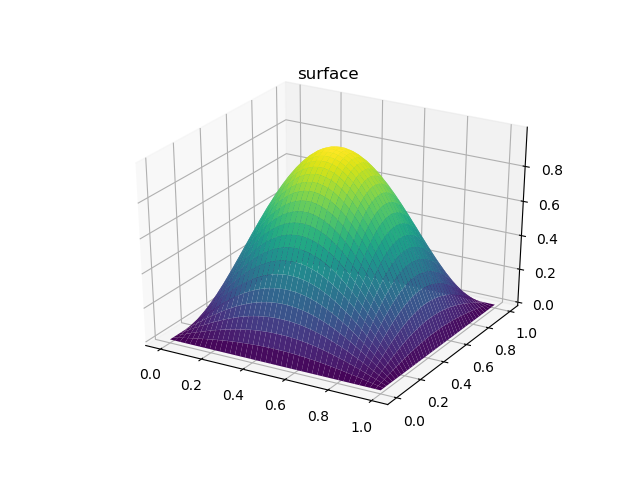

In [94]:
Possion_solver(1, 1, 40, 40, gL, gR, gB, gT, fun)

<IPython.core.display.Javascript object>


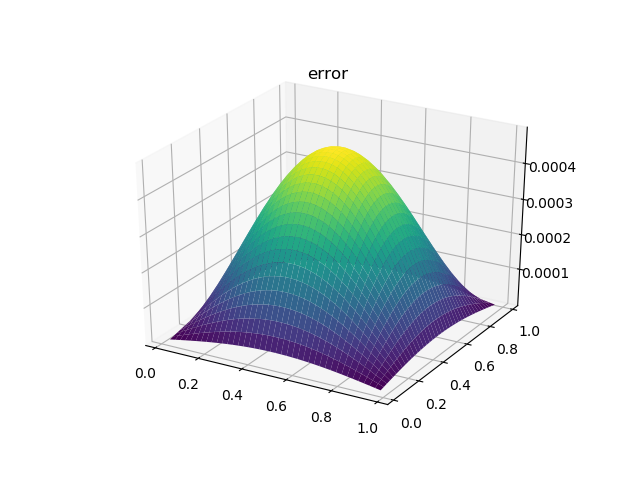

0.0004886981206224661

In [70]:
Possion_error(1, 1, 40, 40, gL, gR, gB, gT, fun, exact_u)

## The Preconditioned Conjugate Gradient Method